In [1]:
from functions import *

# in order to get reproducable results
torch.manual_seed(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(1)
random.seed(1)

import cmapy
time1 = time.time()

print("start reading......")
data_folder = "..<DATA FOLDER>.."
processed_data_folder = "{}/processedThebe".format(data_folder)
ori_data_folder = "{}/thebeorigin".format(data_folder)


# load training set
seismic_path = '{}/seistrain.npy'.format(ori_data_folder)
label_path = '{}/faulttrain.npy'.format(ori_data_folder)
t_start = time.time()
seismic = np.load(seismic_path)
fault = np.load(label_path)
print("load in {} sec".format(time.time()-t_start))

seismic = np.moveaxis(seismic,-2,-1) # make it IL, Z, XL order
fault = np.moveaxis(fault,-2,-1)
seismic = (seismic-seismic.min(axis=(1,2), keepdims=True))/(seismic.max(axis=(1,2), keepdims=True)-seismic.min(axis=(1,2), keepdims=True))

print(seismic.shape, fault.shape)
print(seismic.max(),seismic.min(), fault.max(), fault.min())


IL, Z, XL = fault.shape

im_height = Z
im_width = XL
splitsize = 96
stepsize = 48
overlapsize = splitsize-stepsize
pixelThre = int(0.03*splitsize*splitsize)
print(pixelThre)


horizontal_splits_number = int(np.ceil((im_width-overlapsize)/stepsize))
print("horizontal_splits_number", horizontal_splits_number)
width_after_pad = stepsize*horizontal_splits_number+overlapsize
print("width_after_pad", width_after_pad)
left_pad = int((width_after_pad-im_width)/2)
right_pad = width_after_pad-im_width-left_pad
print("left_pad,right_pad",left_pad,right_pad)

vertical_splits_number = int(np.ceil((im_height-overlapsize)/stepsize))
print("vertical_splits_number",vertical_splits_number)
height_after_pad = stepsize*vertical_splits_number+overlapsize
print("height_after_pad",height_after_pad)
top_pad = int((height_after_pad-im_height)/2)
bottom_pad = height_after_pad-im_height-top_pad
print("top_pad,bottom_pad", top_pad,bottom_pad)


t_start = time.time()
X = []
Y = []
for i in range(0,900,1):
    mask = fault[i]
    splits = split_Image(mask, True,top_pad,bottom_pad,left_pad,right_pad,splitsize,stepsize,vertical_splits_number,horizontal_splits_number)
#     print(splits.shape)
    t = (splits.sum((1,2)) < pixelThre)
    no_label_element_index = list(compress(range(len(t)), t))
    # get all the indexes of the no label pieces by adding elements in axis 2 and 3.
    splits = np.delete(splits, no_label_element_index,0) # delete element i along axis 0
#     print("splits.shape", splits.shape)
    Y.extend(splits)
    
    img = seismic[i]
    splits = split_Image(img, True,top_pad,bottom_pad,left_pad,right_pad,splitsize,stepsize,vertical_splits_number,horizontal_splits_number)
    splits = np.delete(splits, no_label_element_index,0) # delete element i along axis 0
#     print("splits.shape", splits.shape)
    X.extend(splits)
#     break

print(len(Y))
print(len(X))
print(X[0].shape)
print("read images in {} sec".format(time.time()-t_start))

start reading......
load in 21.11854648590088 sec
(900, 1537, 3174) (900, 1537, 3174)
1.0 0.0 True False
276
horizontal_splits_number 66
width_after_pad 3216
left_pad,right_pad 21 21
vertical_splits_number 32
height_after_pad 1584
top_pad,bottom_pad 23 24
181029
181029
(96, 96)
read images in 196.01455879211426 sec


In [2]:
print(X[0].dtype)
X = np.asarray(X, dtype=np.float32)
Y = np.asarray(Y, dtype=np.float32)
print(X[0].dtype)

float64
float32


Optional augmentation

In [3]:
# aug_times = 9

# t_start = time.time()
# origin_train_size = len(X)
# print(origin_train_size)
# X_train_aug = np.zeros((origin_train_size*aug_times,splitsize,splitsize),np.float32)
# Y_train_aug = np.zeros((origin_train_size*aug_times,splitsize,splitsize),np.float32)
# for i in range(len(X)):
#     for j in range(aug_times):
#         aug = strong_aug(p=1)
#         augmented = aug(image=X[i], mask=Y[i])
#         X_train_aug[origin_train_size*j + i] = augmented['image']
#         Y_train_aug[origin_train_size*j + i] = augmented['mask']
# print("read images in {} sec".format(time.time()-t_start))
# print(X_train_aug.dtype)

# if len(X)==origin_train_size:
#     X = np.append(X,X_train_aug, axis=0)
# if len(Y)==origin_train_size:
#     Y = np.append(Y, Y_train_aug, axis=0)
# print("X_train after aug",X.shape, X.dtype) 
# print("Y_train after aug",Y.shape, Y.dtype)
# print("read images in {} sec".format(time.time()-t_start))

In [5]:
directory = "{}/train/seismic".format(processed_data_folder)
if not os.path.exists(directory):
    os.makedirs(directory)
directory = "{}/train/annotation".format(processed_data_folder)
if not os.path.exists(directory):
    os.makedirs(directory)

In [6]:
for i in range(len(X)):
    np.save("{}/train/seismic/{}.npy".format(processed_data_folder, i),X[i])
    np.save("{}/train/annotation/{}.npy".format(processed_data_folder, i),Y[i])

In [6]:
# load validation set
seismic_path = '{}/seisval.npy'.format(ori_data_folder)
label_path = '{}/faultval.npy'.format(ori_data_folder)
t_start = time.time()
seismic = np.load(seismic_path)
fault = np.load(label_path)
print("load in {} sec".format(time.time()-t_start))

seismic = np.moveaxis(seismic,-2,-1) # make it IL, Z, XL order
fault = np.moveaxis(fault,-2,-1)
seismic = (seismic-seismic.min(axis=(1,2), keepdims=True))/(seismic.max(axis=(1,2), keepdims=True)-seismic.min(axis=(1,2), keepdims=True))

print(seismic.shape, fault.shape)
print(seismic.max(),seismic.min(), fault.max(), fault.min())

load in 4.706210374832153 sec
(200, 1537, 3174) (200, 1537, 3174)
1.0 0.0 True False


In [7]:
t_start = time.time()
X = []
Y = []
for i in range(0,200,1):
    mask = fault[i]
    splits = split_Image(mask, True,top_pad,bottom_pad,left_pad,right_pad,splitsize,stepsize,vertical_splits_number,horizontal_splits_number)
#     print(splits.shape)
    t = (splits.sum((1,2)) < pixelThre)
    no_label_element_index = list(compress(range(len(t)), t))
    # get all the indexes of the no label pieces by adding elements in axis 2 and 3.
    splits = np.delete(splits, no_label_element_index,0) # delete element i along axis 0
#     print("splits.shape", splits.shape)
    Y.extend(splits)
    
    img = seismic[i]
    splits = split_Image(img, True,top_pad,bottom_pad,left_pad,right_pad,splitsize,stepsize,vertical_splits_number,horizontal_splits_number)
    splits = np.delete(splits, no_label_element_index,0) # delete element i along axis 0
    X.extend(splits)

print(len(Y))
print(len(X))
print(X[0].shape)
print("read images in {} sec".format(time.time()-t_start))

64317
64317
(96, 96)
read images in 36.502745389938354 sec


In [8]:
X = np.asarray(X, dtype=np.float32)
Y = np.asarray(Y, dtype=np.float32)

In [9]:
directory = "{}/val/seismic".format(processed_data_folder)
if not os.path.exists(directory):
    os.makedirs(directory)
directory = "{}/val/annotation".format(processed_data_folder)
if not os.path.exists(directory):
    os.makedirs(directory)
for i in range(len(X)):
    np.save("{}/val/seismic/{}.npy".format(processed_data_folder, i),X[i])
    np.save("{}/val/annotation/{}.npy".format(processed_data_folder, i),Y[i])

illustrate train or val examples

(-0.5, 95.5, 95.5, -0.5)

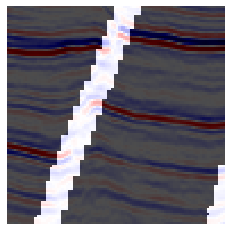

In [11]:
i = 345
seis = np.load("{}/val/seismic/{}.npy".format(processed_data_folder, i))
mask = np.load("{}/val/annotation/{}.npy".format(processed_data_folder, i))
plt.figure(figsize=(4,4))
plt.imshow(seis,'seismic')
plt.imshow(mask, 'gray', alpha=0.7)
plt.axis('off')

(-0.5, 95.5, 95.5, -0.5)

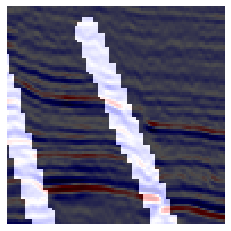

In [12]:
i = 233
seis = np.load("{}/train/seismic/{}.npy".format(processed_data_folder, i))
mask = np.load("{}/train/annotation/{}.npy".format(processed_data_folder, i))
plt.figure(figsize=(4,4))
plt.imshow(seis,'seismic')
plt.imshow(mask, 'gray', alpha=0.7)
plt.axis('off')

In [13]:
# load test set
seismic_path = '{}/seistest.npy'.format(ori_data_folder)
label_path = '{}/faulttest.npy'.format(ori_data_folder)
t_start = time.time()
seismic = np.load(seismic_path)
fault = np.load(label_path)
print("load in {} sec".format(time.time()-t_start))

seismic = np.moveaxis(seismic,-2,-1) # make it IL, Z, XL order
fault = np.moveaxis(fault,-2,-1)
seismic = (seismic-seismic.min(axis=(1,2), keepdims=True))/(seismic.max(axis=(1,2), keepdims=True)-seismic.min(axis=(1,2), keepdims=True))

print(seismic.shape, fault.shape)
print(seismic.max(),seismic.min(), fault.max(), fault.min())

load in 17.432120323181152 sec
(703, 1537, 3174) (703, 1537, 3174)
1.0 0.0 True False


In [14]:
directory = "{}/test/seismic".format(processed_data_folder)
if not os.path.exists(directory):
    os.makedirs(directory)
directory = "{}/test/annotation".format(processed_data_folder)
if not os.path.exists(directory):
    os.makedirs(directory)
count = 0
for i in range(0,len(seismic),5):
    np.save("{}/test/seismic/{}.npy".format(processed_data_folder, count),seismic[i])
    np.save("{}/test/annotation/{}.npy".format(processed_data_folder, count),fault[i])
    count = count + 1